<a href="https://colab.research.google.com/github/edakavlakoglu/mids/blob/master/Eda_Kavlakoglu_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [ ]:
def Q1(num_examples=5):
  for x in range(num_examples):
    print("Text of message", x+1, ":\n \n", train_data[x])
    print("\n")
    print("Label for message", x+1,":", newsgroups_train.target_names[train_labels[x]])
    print("\n")
Q1(5)


Text of message 1 :
 
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Label for message 1 : comp.graphics


Text of message 2 :
 
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil c

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [ ]:
##CREDIT TO SOURCES##
#https://github.com/MIDS-W207/ramesh-coursework/blob/main/LiveSessions/week07/logistic%20regression%20-%20answer.ipynb
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created
#https://stackoverflow.com/questions/1165352/calculate-difference-in-keys-contained-in-two-python-dictionaries

def Q2():

  #PART 1 - create unigram word feature vectors
    vectorizer = CountVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    
    #print the size of the vocabulary
    print("Size of the vocabulary:", vtrain.shape[1])

    #print the average number of non-zero features per example
    avg = vtrain.nnz/vtrain.shape[0]
    print("Avg Number of Non-Zero Features per Example: {:.2f}".format(avg))
  
    #print fraction of the non-zero entries in the matrix
    array_sz = vtrain.shape[0]*vtrain.shape[1]
    fract = vtrain.nnz/array_sz
    print("Fraction of non-zero entries in matrix: {:.2%}".format(fract)) 

    #print the feature strings at the 0 and last index 
    print("Feature string at 0 index:", vectorizer.get_feature_names()[0])
    print("Feature string at last index:", vectorizer.get_feature_names()[-1])
 
  #PART 2 - create unigram word feature vectors w/ vocabulary restrictions
    vectorizer2 = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    vtrain2 = vectorizer2.fit_transform(train_data)

    #print the average number of non-zero features per example
    avg2 = vtrain2.nnz/vtrain2.shape[0]
    print("Avg Number of Non-Zero Features per Example: {:.2f}".format(avg2))

  #PART 3 - create character bigram and trigram feature vectors

    #bigram
    vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(2, 2))
    vtrain3 = vectorizer3.fit_transform(train_data)
    print("Size of the Bigram vocabulary:", vtrain3.shape[1])

    #trigram
    vectorizer4 = CountVectorizer(analyzer='char', ngram_range=(3, 3))
    vtrain4 = vectorizer4.fit_transform(train_data)
    print("Size of the Trigram vocabulary:", vtrain4.shape[1])

    #combined: bigram + trigram
    vectorizer5 = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    vtrain5 = vectorizer5.fit_transform(train_data)
    print("Size of combined Bigram and Trigram vocabulary:", vtrain5.shape[1])

  #PART 4 - create word unigram feature vectors and prune words that appear in fewer than 10 documents
    vectorizer6 = CountVectorizer(min_df=10)
    vtrain6 = vectorizer6.fit_transform(train_data)
    print("Size of the vocabulary where word appear in less than 10 documents:", vtrain6.shape[1])
      
  #PART 5 - find fraction of words in the dev vocabulary that is missing from the train vocab
    train_vocab = vectorizer.vocabulary_

    vectorizer7 = CountVectorizer()
    vtrain7 = vectorizer7.fit_transform(dev_data)
    dev_vocab = vectorizer7.vocabulary_

    #calculate difference in vocabularies
    diff =  set(dev_vocab.keys()) - set(train_vocab.keys())
    diff_length = len(diff)
    fract_missing = diff_length/len(dev_vocab)
    print("Number of words missing in the training vocab:", diff_length)
    print("Fraction of words in the dev vocabulary that is missing from the train vocab: {:.2%}".format(fract_missing))

    
Q2()

Size of the vocabulary: 26879
Avg Number of Non-Zero Features per Example: 96.71
Fraction of non-zero entries in matrix: 0.36%
Feature string at 0 index: 00
Feature string at last index: zyxel
Avg Number of Non-Zero Features per Example: 0.27
Size of the Bigram vocabulary: 3291
Size of the Trigram vocabulary: 32187
Size of combined Bigram and Trigram vocabulary: 35478
Size of the vocabulary where word appear in less than 10 documents: 3064
Number of words missing in the training vocab: 4027
Fraction of words in the dev vocabulary that is missing from the train vocab: 24.79%


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [ ]:
##CREDIT TO SOURCES##
#https://stackoverflow.com/questions/38692520/what-is-the-difference-between-fit-transform-and-transform-in-sklearn-countvecto
#https://stackoverflow.com/questions/50290273/gridsearchcv-representation-of-each-class-in-each-part-of-the-dataframe
#code from project 1 & 2 
#https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/
#https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression
#https://realpython.com/logistic-regression-python/

def Q3():
    
    #generate transformed data
    vectorizer = CountVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)

    #define k values for testing
    k_values = [1, 3, 5, 7, 9]
    print("\nKNN F1 Scores")

    #create and fit KNN model
    for k in k_values:
      knn_model = KNeighborsClassifier(n_neighbors=k) 
      knn_model.fit(vtrain, train_labels) 
      train_predicted_labels = knn_model.predict(vdev) 
      f1_knn = metrics.f1_score(dev_labels, train_predicted_labels, average='weighted')
      print("Model with k =", k, "has an F1 score of {:.2%}".format(f1_knn))
    
    #define alpha values for testing
    alpha_values = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    print("\nMultinomial NB F1 Scores")

    #create and fit Multinomial NB model
    for a in alpha_values:
      nb_model = MultinomialNB(alpha=a)
      nb_model.fit(vtrain, train_labels)
      nb_train_predicted_labels = nb_model.predict(vdev) 
      f1_nb = metrics.f1_score(dev_labels, nb_train_predicted_labels, average='weighted')
      print("Model with alpha =", a, "has an F1 score of {:.2%}".format(f1_nb))

    #define c values for testing
    c_values = [0.001,0.01,0.1,1,10,100]
    print("\nLogistic Regression F1 Scores")

    #create and fit Logistic Regression model
    for c in c_values:
      lr_model = LogisticRegression(penalty='l2', C = c, solver="liblinear", multi_class="auto")
      lr_model.fit(vtrain, train_labels)
      lr_train_predicted_labels = lr_model.predict(vdev) 
      lr_nb = metrics.f1_score(dev_labels, lr_train_predicted_labels, average='weighted')
      ssw = []
      for i in range(len(lr_model.coef_)):
        sum_sq_weights = sum([w**2 for w in lr_model.coef_[i]])
        ssw.append(sum_sq_weights)
      print("Model with C =", c, "has an F1 score of {:.2%}".format(lr_nb), "and the following sum of squared weights:", ssw) 

Q3()




KNN F1 Scores
Model with k = 1 has an F1 score of 38.05%
Model with k = 3 has an F1 score of 40.84%
Model with k = 5 has an F1 score of 42.88%
Model with k = 7 has an F1 score of 45.05%
Model with k = 9 has an F1 score of 43.66%

Multinomial NB F1 Scores
Model with alpha = 1e-10 has an F1 score of 74.72%
Model with alpha = 0.0001 has an F1 score of 76.28%
Model with alpha = 0.001 has an F1 score of 77.03%
Model with alpha = 0.01 has an F1 score of 77.52%
Model with alpha = 0.1 has an F1 score of 79.03%
Model with alpha = 0.5 has an F1 score of 78.63%
Model with alpha = 1.0 has an F1 score of 77.77%
Model with alpha = 2.0 has an F1 score of 76.90%
Model with alpha = 10.0 has an F1 score of 66.75%

Logistic Regression F1 Scores
Model with C = 0.001 has an F1 score of 61.93% and the following sum of squared weights: [0.16509345166731987, 0.20095274690581916, 0.180670937543784, 0.18724278437848627]
Model with C = 0.01 has an F1 score of 66.47% and the following sum of squared weights: [2.

ANSWER: 
5. KNN doesn't perform well in high dimensional spaces (i.e. the curse of dimensionality). 
6. Naive Bayes outperforms Logistic Regression because it assumes conditional independence. 
7. According to the scikit-learn documentation, the C value is "the inverse of regularization strength", so smaller c values yield stronger regularization (i.e. higher penalty on higher values of the coefficients or weights). 

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [ ]:
##CREDIT TO SOURCES##
#https://stackoverflow.com/questions/43576614/logistic-regression-how-to-find-top-three-feature-that-have-highest-weights
#https://stackoverflow.com/questions/56161654/how-to-select-top-10-features-from-a-list-of-features-and-a-list-of-weight-coeff
#https://stackoverflow.com/questions/11858159/displaying-python-2d-list-without-commas-brackets-etc-and-newline-after-every
#https://www.codegrepper.com/code-examples/python/pandas+set+first+row+as+column+names
#https://stackoverflow.com/questions/24644656/how-to-print-pandas-dataframe-without-index

def Q4():
    
    #transform data to a matrix of word bigrams
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
    vtrain = vectorizer.fit_transform(train_data)

    #produce logistic regression model
    model = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
    model.fit(vtrain, train_labels)

    #get weights
    weights = model.coef_

    #get index of weights in descending order
    sorted_index = (-weights).argsort(axis=1)
    top_5_indices = sorted_index[:, 0:5]
    fltnd_index_array = top_5_indices.flatten()

    #get features
    vocab = list(vectorizer.vocabulary_.keys())
    top_5_vocab = []

    for x in fltnd_index_array:
      feature = np.array(vectorizer.get_feature_names()[x])
      top_5_vocab.append(feature)
  
    #get topics
    topics = newsgroups_train.target_names

    #add empty string at index 1 to match the size of weight and feature array 
    if len(topics) == 4: 
      topics.insert(0, " ")

    #create empty array
    top_5_array = np.zeros((4, 20))

    for row in range(len(top_5_array)):
        for col in range(len(top_5_array[0])):
          top_5_array [row, col] = round(weights[row, fltnd_index_array[col]], 2)

    #combine weight matrix and features and topics
    feature_weight_matrix = np.vstack((top_5_vocab, top_5_array)).transpose()
    fwt_matrix = np.vstack((topics, feature_weight_matrix))

    #convert to dataframe for formatting
    fwt_matrix = pd.DataFrame(fwt_matrix)
    fwt_matrix.style.hide_index()
    print(fwt_matrix.to_string(index=False))

Q4()

             0            1              2          3                   4
                alt.atheism  comp.graphics  sci.space  talk.religion.misc
    claim that       0.6055        -0.1991    -0.2743             -0.1404
   cheers kent       0.5557        -0.6979    -0.6638              0.5348
      was just       0.4821        -0.1314    -0.1289             -0.2275
       you are       0.4727        -0.2799    -0.4813              0.0284
       are you        0.447        -0.2483    -0.0971             -0.3056
   looking for      -0.6303         1.1084       -0.5             -0.5719
    in advance      -0.4594         0.8326    -0.4385             -0.4185
 comp graphics      -0.2922         0.8012    -0.3709             -0.2852
     out there      -0.2748         0.7587    -0.4791             -0.2771
      is there      -0.3409          0.755    -0.4682             -0.2571
     the space      -0.2682        -0.5301     0.8711             -0.2738
      the moon      -0.3506        -0.

ANSWER: When we compare the weights of the features across topics, the features with the largest weights for a given topic yield negative weights for the other topics with one exception. "cheers kent" appears within the top 5 for two topics, alt.atheism and talk.religion.misc.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [ ]:
#CREDIT TO SOURCES#
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#https://stackoverflow.com/questions/54403529/remove-apostrophe-from-string-python-regex
#https://stackabuse.com/removing-stop-words-from-strings-in-python/
#https://www.codecademy.com/learn/text-preprocessing/modules/nlp-text-preprocessing
#https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number
#https://medium.com/@cmukesh8688/scikit-learn-count-vectorizers-32b58dee0541
#https://stackoverflow.com/questions/1480040/regular-expression-removing-all-words-shorter-than-n
#https://towardsdatascience.com/regex-essential-for-nlp-ee0336ef988d

def no_preprocess(word):
  return word

def preprocess(words):
    words= words.lower() #convert to lowercase
    words = re.sub("(?<=[a-z])'(?=[a-z])", "", words) #remove apostrophes
    return words

def Q5():
    #with no preprocessing

    #transform data to a matrix of word bigrams
    vectorizer = CountVectorizer(preprocessor=no_preprocess)
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)

    #produce logistic regression model
    model = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
    model.fit(vtrain, train_labels)
    train_predicted_labels = model.predict(vdev) 
    score = metrics.f1_score(dev_labels, train_predicted_labels, average='weighted')
    print("Vocabulary size with no pre-processing:", vtrain.shape[1])
    print("F1 score with no pre-processing: {:.2%}".format(score))

    #with preprocessing
    #transform data to a matrix of word bigrams
    vectorizer_p = CountVectorizer(preprocessor=preprocess, stop_words='english')
    vtrain_p = vectorizer_p.fit_transform(train_data)
    vdev_p = vectorizer_p.transform(dev_data)

    #produce logistic regression model
    model_p = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
    model_p.fit(vtrain_p, train_labels)
    train_predicted_labels_p = model_p.predict(vdev_p) 
    score_p = metrics.f1_score(dev_labels, train_predicted_labels_p, average='weighted')
    
    #difference in F1 score
    score_diff = score_p - score
    # print("{:.2f}".format(score_diff))
    
    #difference in vocabulary sizes 
    diff = vtrain.shape[1] - vtrain_p.shape[1]

    print("Vocabulary size with pre-processing:", vtrain_p.shape[1])
    print("F1 score with pre-processing: {:.2%}".format(score_p))
    print("The improved model reduced the vocabulary size by", diff)

Q5()

Vocabulary size with no pre-processing: 33291
F1 score with no pre-processing: 70.69%
Vocabulary size with pre-processing: 26901
F1 score with pre-processing: 73.10%
The improved model reduced the vocabulary size by 6390


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)


L1 regularization strength (C value) for L1 model: 0.001
Size of reduced vocab for L2 model: 2
F1 score of L2 model: 13.39%

L1 regularization strength (C value) for L1 model: 0.01
Size of reduced vocab for L2 model: 18
F1 score of L2 model: 13.71%

L1 regularization strength (C value) for L1 model: 0.1
Size of reduced vocab for L2 model: 221
F1 score of L2 model: 18.98%

L1 regularization strength (C value) for L1 model: 0.5
Size of reduced vocab for L2 model: 739
F1 score of L2 model: 34.15%

L1 regularization strength (C value) for L1 model: 1
Size of reduced vocab for L2 model: 1169
F1 score of L2 model: 40.93%

L1 regularization strength (C value) for L1 model: 10
Size of reduced vocab for L2 model: 3577
F1 score of L2 model: 55.28%

L1 regularization strength (C value) for L1 model: 100
Size of reduced vocab for L2 model: 7875
F1 score of L2 model: 59.65%


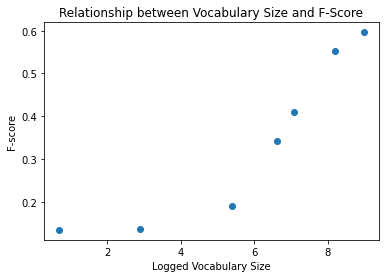

In [ ]:
##CREDIT TO SOURCES##
#https://stackoverflow.com/questions/7088625/what-is-the-most-efficient-way-to-check-if-a-value-exists-in-a-numpy-array
#https://stackoverflow.com/questions/15114843/accessing-dictionary-value-by-index-in-python

def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    c_values = [0.001,0.01,0.1, 0.5, 1,10,100]
    vocab_lengths = []
    scores = []

    for c in c_values: 

      #generate transformed data
      vectorizer = CountVectorizer()
      vtrain = vectorizer.fit_transform(train_data)
      vdev = vectorizer.transform(dev_data)

      #Logistic Regression with L1 strength
      L1_model = LogisticRegression(penalty='l1', C = c, solver="liblinear", multi_class="auto", tol=0.015)
      L1_model.fit(vtrain, train_labels)
      L1_train_predicted_labels = L1_model.predict(vdev) 
      L1_fscore = metrics.f1_score(dev_labels, L1_train_predicted_labels, average='weighted')

      #calculate weights
      weights = L1_model.coef_

      col_index = []

      #loop through weights, identify columns with weights greater than zero
      for i in range(len(weights[0])):
        if weights[:,i].any() > 0:
          col_index.append(i)

      col_index = np.array(col_index)  

      #reduce the initial vocab
      vocab = vectorizer.vocabulary_
      vocab_list = list(vocab.keys())

      reduced_vocab = []

      for x in col_index:
        key = vocab_list[x]
        reduced_vocab.append(key)

      #store vocabulary lengths
      v_length = len(reduced_vocab)
      vocab_lengths.append(v_length)
    
      #generate transformed data with reduced vocab
      vectorizer2 = CountVectorizer(vocabulary=reduced_vocab)
      vtrain2 = vectorizer2.fit_transform(train_data)
      vdev2 = vectorizer2.transform(dev_data)

      #Logistic Regression with L2 strength
      L2_model = LogisticRegression(penalty='l2', C=0.5, solver="liblinear", multi_class="auto", tol=0.015)
      L2_model.fit(vtrain2, train_labels)
      L2_train_predicted_labels = L2_model.predict(vdev2) 
      L2_fscore = metrics.f1_score(dev_labels, L2_train_predicted_labels, average='weighted')

      #store f1 scores in list
      scores.append(L2_fscore)

      print("\nL1 regularization strength (C value) for L1 model:", c)
      print("Size of reduced vocab for L2 model:", v_length)
      print("F1 score of L2 model: {:.2%}".format(L2_fscore))

    #scatterplot of f1 score and logged vocabulary sizes 
    logged_vl = np.log(vocab_lengths)
    plt.scatter(logged_vl, scores, marker='o')
    plt.title("Relationship between Vocabulary Size and F-Score")
    plt.xlabel("Logged Vocabulary Size")
    plt.ylabel("F-score")

    ### STUDENT END ###

Q6()

ANSWER: 

3. As the size of the vocabulary increases, the f-score value also increases. The rate in which the f-score value increases becomes steeper after the vocabulary size exceeds 700.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [ ]:
##CREDIT TO SOURCES##
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
#https://stackoverflow.com/questions/36681449/scikit-learn-return-value-of-logisticregression-predict-proba
#https://numpy.org/doc/stable/reference/generated/numpy.amax.html
#https://www.geeksforgeeks.org/convert-python-list-to-numpy-arrays/

def Q7():
   #generate TfidfVectorizer data
    vectorizer = TfidfVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)

    #generate logistic model
    model = LogisticRegression(penalty='l2', C = 100, solver="liblinear", multi_class="auto")
    model.fit(vtrain, train_labels)
    train_predicted_labels = model.predict(vdev) 
    score = metrics.f1_score(dev_labels, train_predicted_labels, average='weighted')
    print("F1 score: {:.2%}".format(score)) 

    #calculate probabilities 
    p = model.predict_proba(vdev)

    #calculate r ratios 
    r_ratios = []

    for index in range(len(p)):
      max_p = np.amax(p[index])
      correct_p = p[index][dev_labels[index]]
      r = max_p / correct_p
      r_ratios.append(r)

    r_ratios = np.array(r_ratios)  
  
    #find indices of top 3 docs 
    sorted_index = (-r_ratios).argsort(axis=0)
    top_3_indices = sorted_index[0:3]

    #print docs with the highest R ratio
    for x in top_3_indices:
      print("\nR ratio: {:.2f}".format(r_ratios[x]))
      #print("Classification Label:", newsgroups_train.target_names[dev_labels[x]])
      #print("Classification Label:", newsgroups_train.target_names[train_predicted_labels[x]])
      print("\nDocument:\n", dev_data[x])

Q7()

F1 score: 75.98%

R ratio: 929.36

Document:
 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in th

ANSWER: 
1. TFIDFVectorizer doesn't just provide a frequency count of words within a document, like CountVectorizer. It assigns a score, where high frequency words are penalized as TFIDFVectorizer works under the assumption that less common words provide more contextual value. 

3. The R ratio shows the documents with the highest likelihood to predict the wrong topic.

4. The model isn't classifying the docs with the highest r ratios correctly. A solution may be to remove words that may be confusing to classify (e.g. Mormon).

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.